# L0

In [1]:
import pandas as pd
import os

file_path = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/Mar_26_P31/Pandora31s1_CharlesCityVA_20240825/Pandora31s1_CharlesCityVA_20240825_L0.txt'

base_name = os.path.basename(file_path)
csv_file_name = os.path.splitext(base_name)[0] + '.csv'

# Read the entire file
with open(file_path, 'r', encoding='latin1') as file:
    lines = file.readlines()

# Skip the initial 44 rows
data_lines = lines[44:]

# Process each line to split into rows and columns
data_list = []
for line in data_lines:
    # Strip the newline character and split by tabs
    rows = line.strip().split('\t')
    for row in rows:
        # Split each row by spaces
        columns = row.split()
        data_list.append(columns)

# Convert the list of lists into a DataFrame
data1 = pd.DataFrame(data_list)
# Convert the necessary columns to numeric before saving
data1.iloc[:, 2:4128] = data1.iloc[:, 2:4128].apply(pd.to_numeric, errors='coerce')

# Define the column names
column_names = [
    'routine', 'time (yyyymmddThhmmssZ)', 'Routine count', 'Repetition count', 'measurement duration (s)',
    'Integration time [ms]', 'Number of cycles', 'Saturation index', 'filterwheel 1', 'filterwheel 2',
    'Pointing zenith angle (degree)', 'Zenith pointing mode', 'Pointing azimuth (degree)', 'Azimuth pointing mode',
    'Data processing type', 'Target distance [m]', 'Temperature at electronics board (C)',
    'Spectrometer control temperature (C)', 'Auxiliary spectrometer temperature (C)', 'Temperature in head sensor (C)',
    'Humidity in head sensor (%)', 'Pressure in head sensor (hPa)', 'Scale factor for data', 'Uncertainty indicator'
] + [f'Mean pixel {i}' for i in range(1, 2053)] + [f'Uncertainty {i}' for i in range(1, 2053)]

# Assign column names to the DataFrame
# data1.columns = column_names

save_folder = "/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/Mar_26_P31/Pandora31s1_CharlesCityVA_20240825/"

# Save the DataFrame to a CSV file with the same name as the initial text file
#data1.to_csv(os.path.join(save_folder, csv_file_name), index=False)

print(f"Data saved to {os.path.join(save_folder, csv_file_name)}")

Data saved to /Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/Mar_26_P31/Pandora31s1_CharlesCityVA_20240825/Pandora31s1_CharlesCityVA_20240825_L0.csv


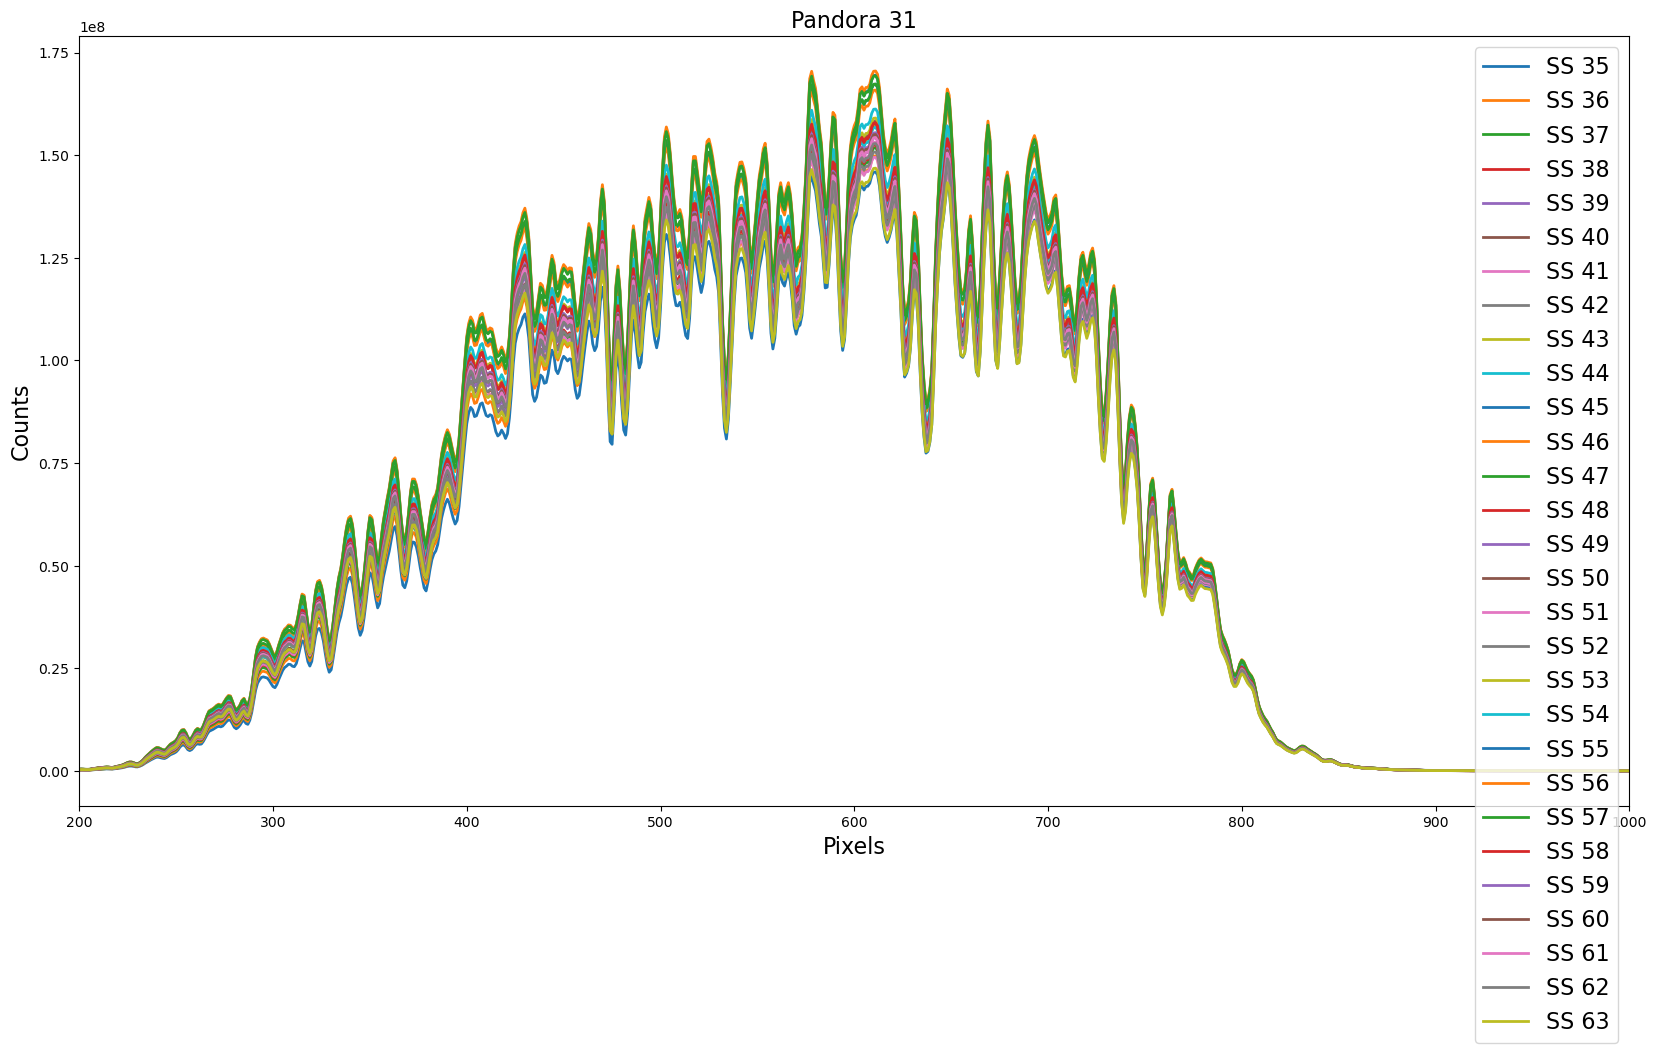

In [123]:
# Define the conditions
conditions = {
    "SS_bc": (data1[0] == "SS") & (data1[8] == 1) & (data1[9] == 5),
    "SS_dc": (data1[0] == "SS") & (data1[8] == 1) & (data1[9] == 3)
}

# Create variables for filtered data
filtered_data = {key: data1.loc[condition, 21:2071] for key, condition in conditions.items()}

# Extract the data and calculate the mean
SS_bc_l0 = filtered_data["SS_bc"].reset_index(drop=True)
SS_dc_l0 = filtered_data["SS_dc"].reset_index(drop=True)

SS_bc = SS_bc_l0.iloc[:, 3:].values
SS_dc = SS_dc_l0.iloc[:, 3:].values

ss_l0 = SS_bc - SS_dc

pixels = np.arange(0, 2048)

plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.xticks(np.arange(0, 2048, 100))
for i in range(35,64): 
    plt.plot(pixels, ss_l0[i], label=f'SS {i}', linewidth=2)

plt.xlabel('Pixels', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Pandora 31', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(200, 1000)
#plt.ylim(50, 120)
plt.show()

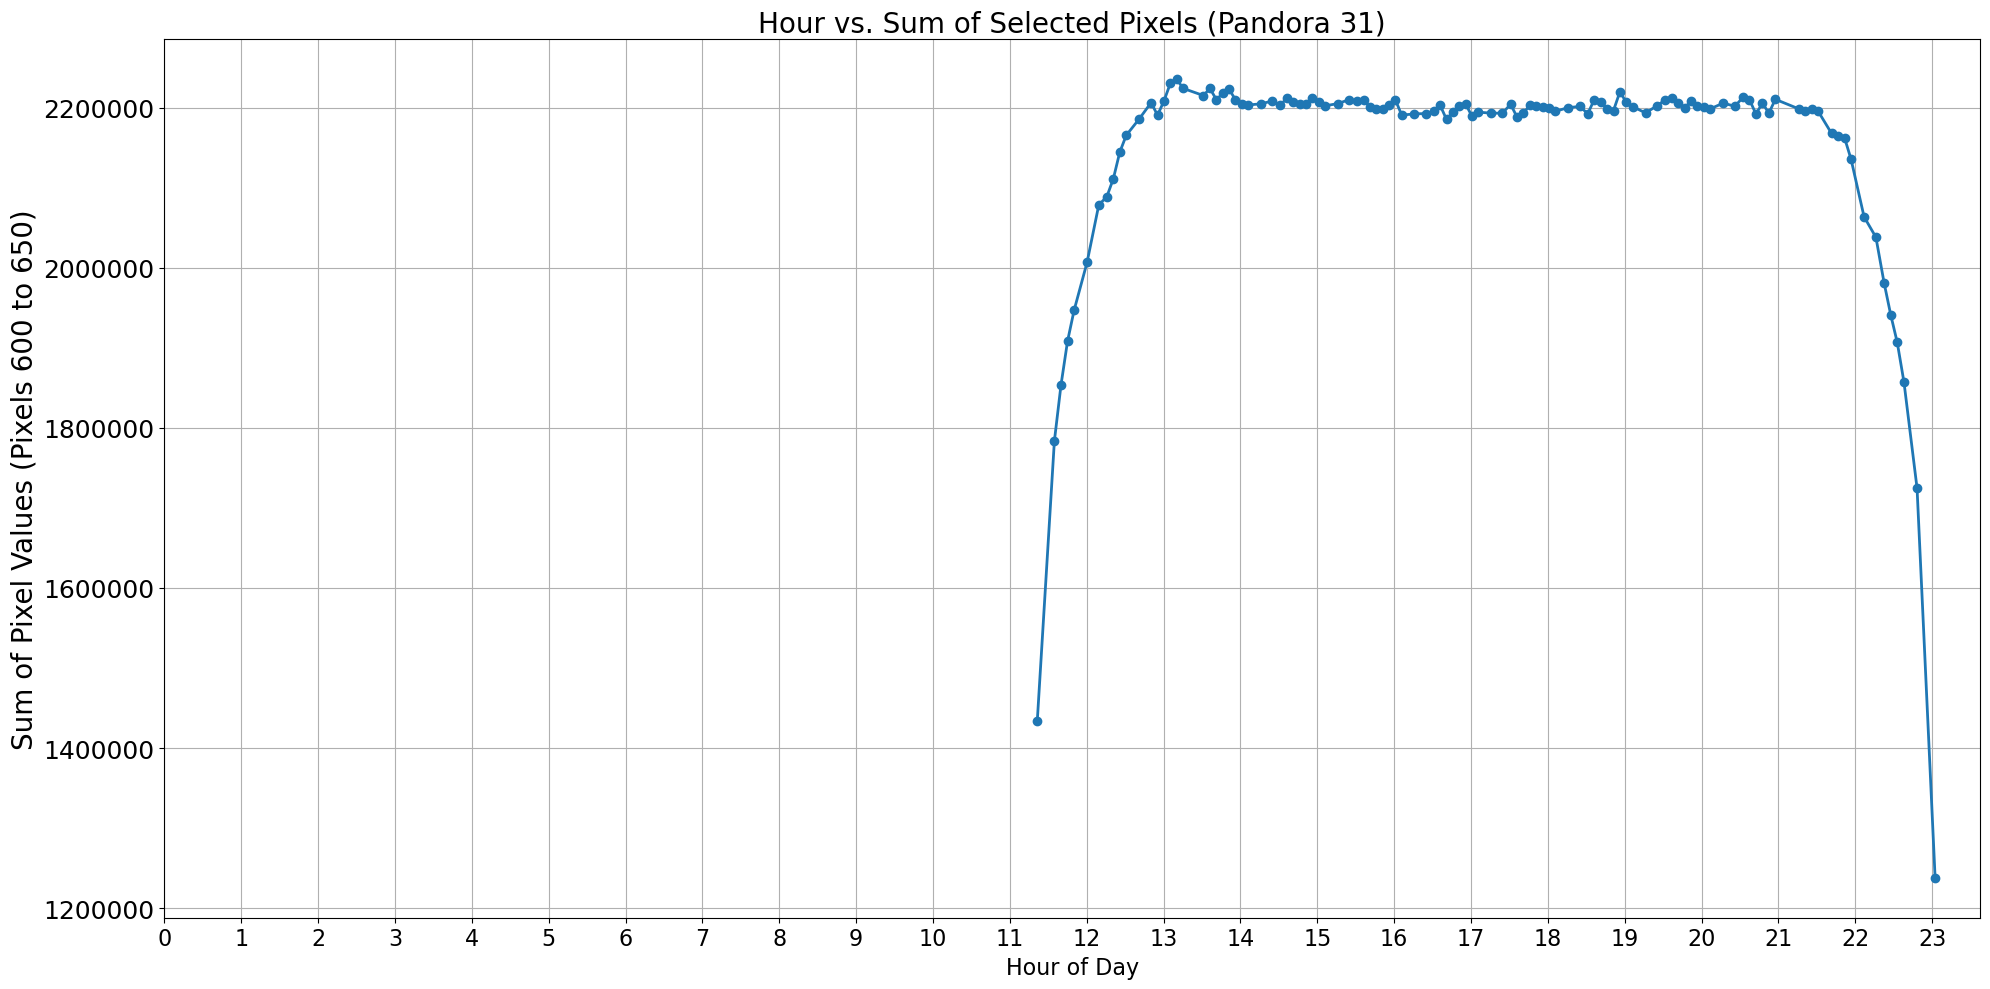

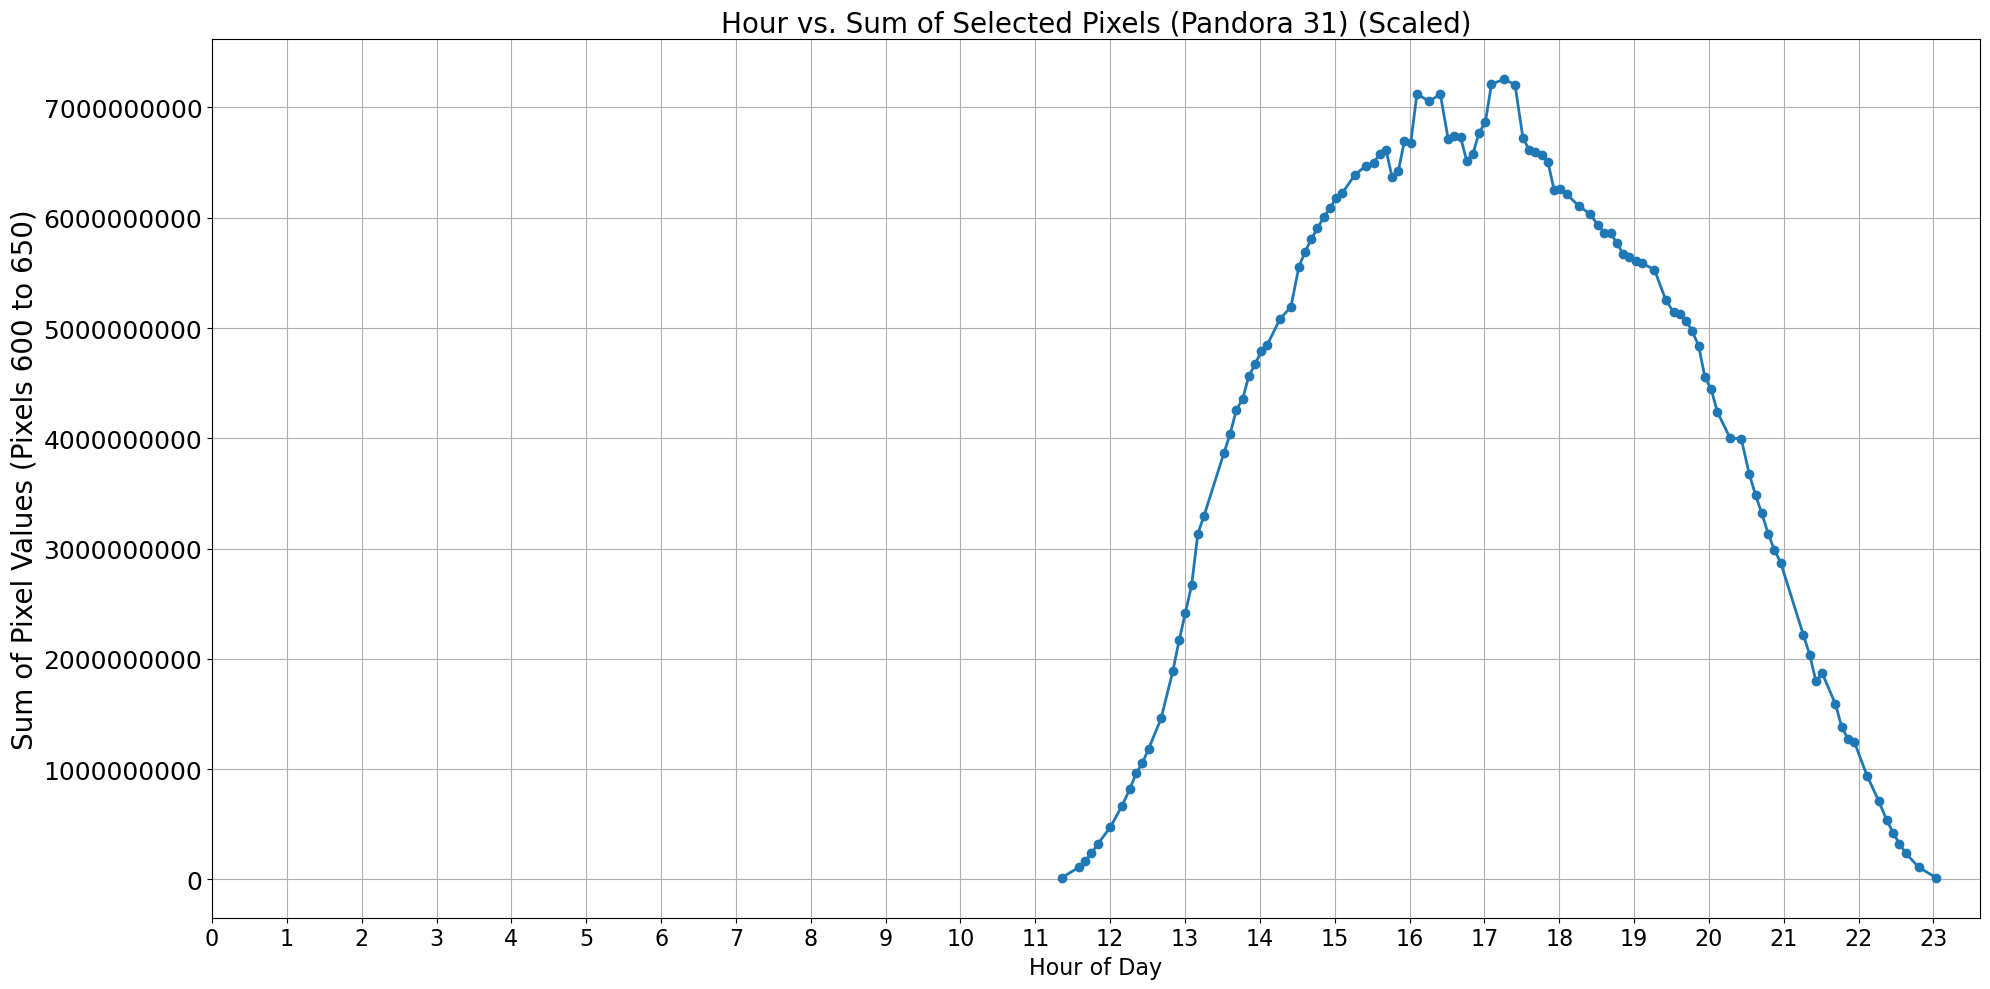

In [215]:
# Define the conditions
conditions = {
    "SS_bc": (data1[0] == "SS") & (data1[8] == 1) & (data1[9] == 5),
    "SS_dc": (data1[0] == "SS") & (data1[8] == 1) & (data1[9] == 3)
}

# Extract scale factor column (index 23 as per your column list)
scale_factor_bc = SS_bc_full.iloc[:, 22].astype(float).values  # shape: (n_bc,)
scale_factor_dc = SS_dc_full.iloc[:, 22].astype(float).values  # shape: (n_dc,)

# Full filtered DataFrame with metadata (including time)
SS_bc_full = data1.loc[conditions["SS_bc"]].reset_index(drop=True)
SS_dc_full = data1.loc[conditions["SS_dc"]].reset_index(drop=True)

# Extract and normalize pixel data (columns 24 to 2071, i.e., 2048 columns)
SS_bc_scaled = SS_bc_full.iloc[:, 24:2072].astype(float).values
SS_dc_scaled = SS_dc_full.iloc[:, 24:2072].astype(float).values

SS_bc = SS_bc_full.iloc[:, 24:2072].astype(float).values / scale_factor_bc[:, np.newaxis]
SS_dc = SS_dc_full.iloc[:, 24:2072].astype(float).values / scale_factor_dc[:, np.newaxis]

ss_l0 = SS_bc - SS_dc
ss_l0_scaled = SS_bc_scaled - SS_dc_scaled

# Sum of pixel values from 600 to 650
pixel_start = 600
pixel_end = 650
sum_pixels = ss_l0[:, pixel_start:pixel_end + 1].sum(axis=1)
sum_pixels_scaled = ss_l0_scaled[:, pixel_start:pixel_end + 1].sum(axis=1)

# Extract time strings from column index 1
time_strings = SS_bc_full.iloc[:, 1].astype(str)

# Clean and convert to hour
from datetime import datetime
import numpy as np
hours = []
valid_sum_pixels = []
valid_sum_pixels_scaled = []

for i, t in enumerate(time_strings):
    try:
        cleaned_time = t.replace('Z', '')
        if '.' in cleaned_time:
            cleaned_time = cleaned_time.split('.')[0]
        dt = datetime.strptime(cleaned_time, "%Y%m%dT%H%M%S")
        hour = dt.hour + dt.minute/60 + dt.second/3600
        hours.append(hour)
        valid_sum_pixels.append(sum_pixels[i])
        valid_sum_pixels_scaled.append(sum_pixels_scaled[i])
    except Exception as e:
        print(f"Error parsing time '{t}': {e}")

# Convert to arrays
hours = np.array(hours)
valid_sum_pixels = np.array(valid_sum_pixels)
valid_sum_pixels_scaled = np.array(valid_sum_pixels_scaled)

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(hours, valid_sum_pixels, marker='o', linewidth=2)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel(f'Sum of Pixel Values (Pixels {pixel_start} to {pixel_end})', fontsize=20)
plt.title('Hour vs. Sum of Selected Pixels (Pandora 31)', fontsize=20)
plt.grid(True)
plt.xticks(np.arange(0, 24, 1), fontsize=16)
plt.yticks(fontsize=18)

# Disable scientific notation on y-axis
from matplotlib.ticker import ScalarFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(hours, valid_sum_pixels_scaled, marker='o', linewidth=2)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel(f'Sum of Pixel Values (Pixels {pixel_start} to {pixel_end})', fontsize=20)
plt.title('Hour vs. Sum of Selected Pixels (Pandora 31) (Scaled)', fontsize=20)
plt.grid(True)
plt.xticks(np.arange(0, 24, 1), fontsize=16)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


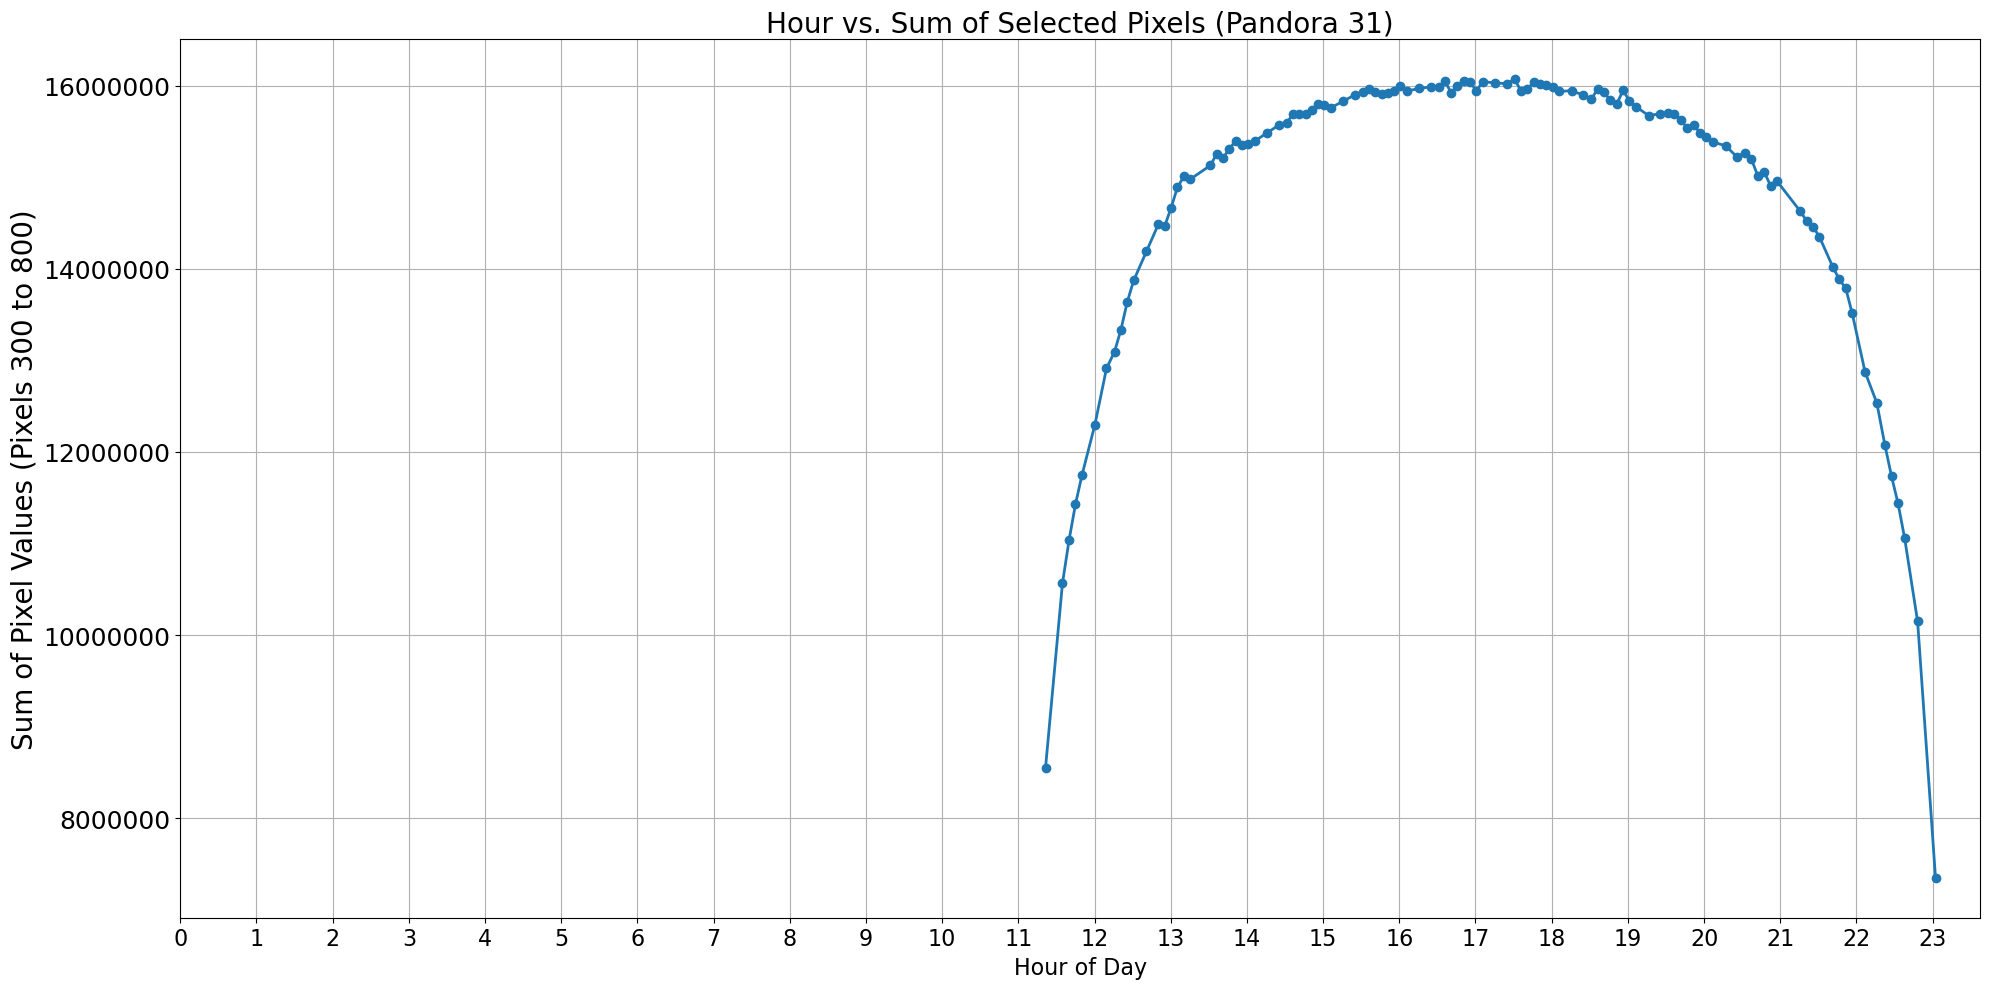

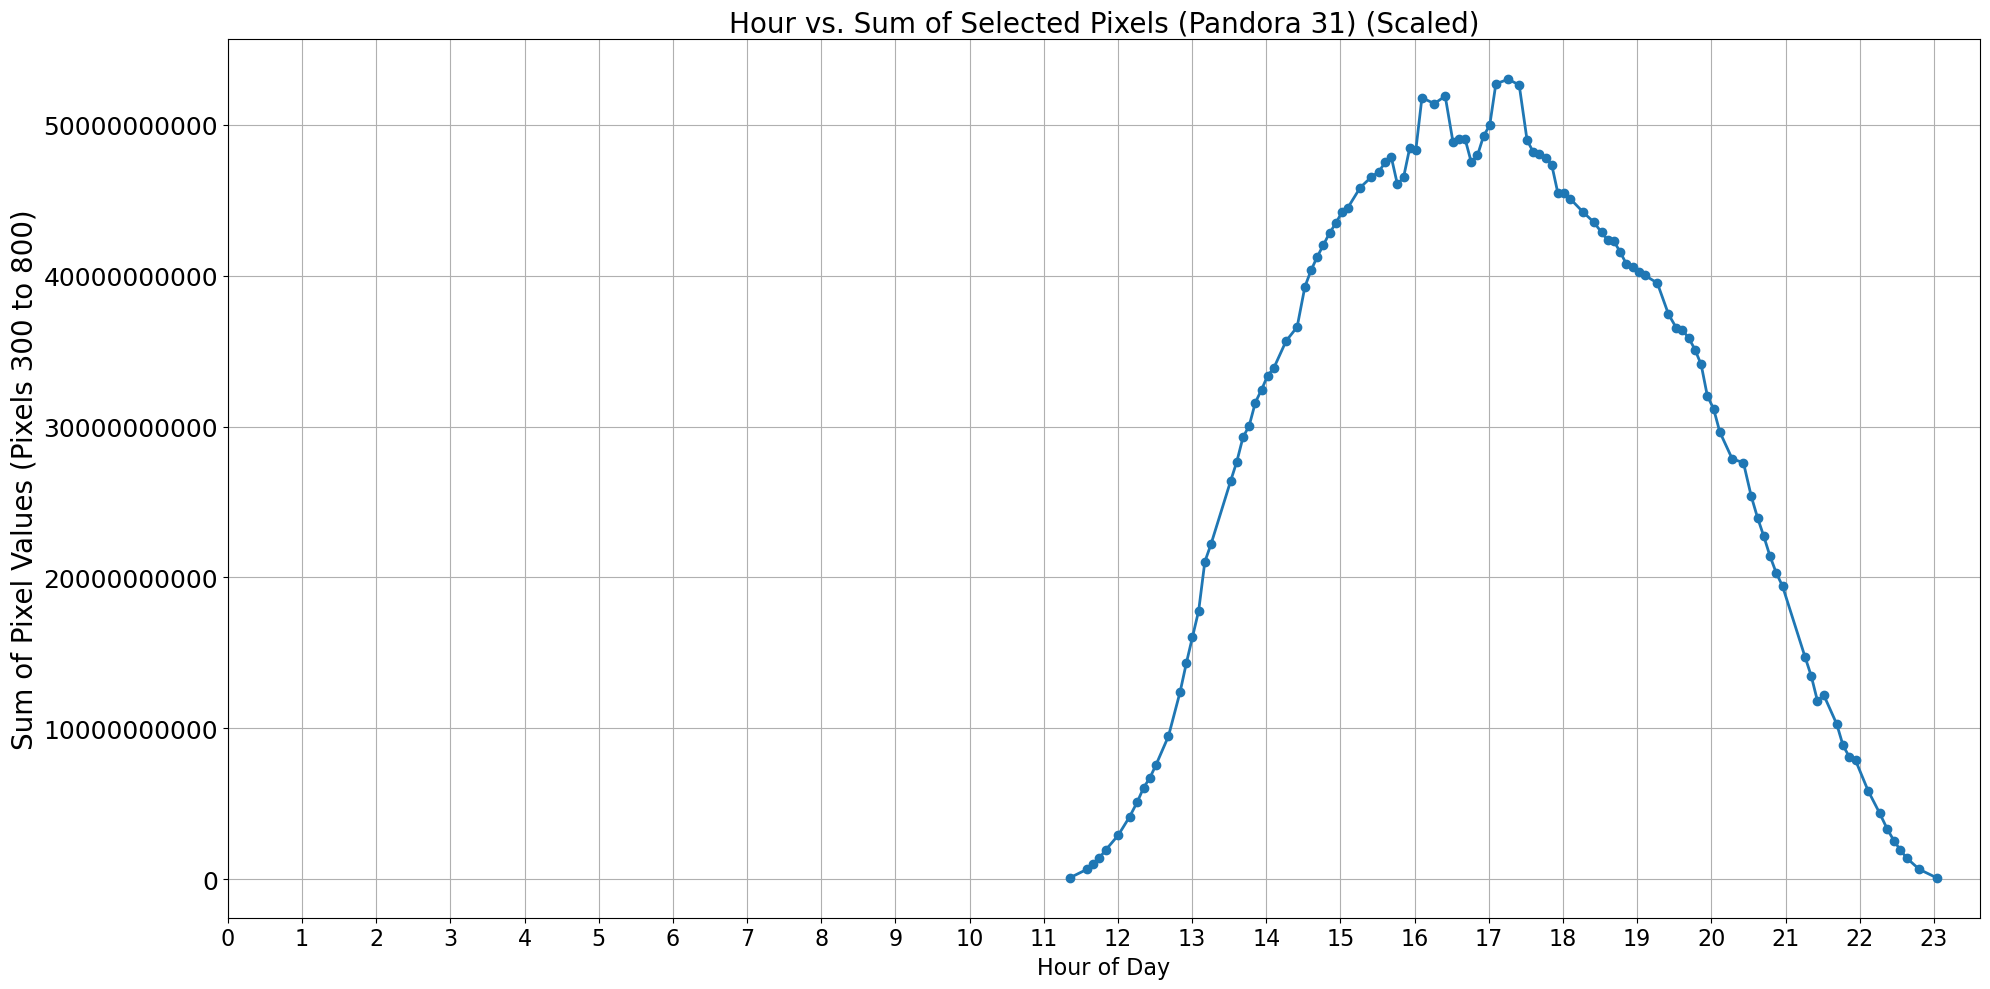

In [201]:
# Sum of pixel values from 600 to 650
pixel_start = 300
pixel_end = 800
sum_pixels = ss_l0[:, pixel_start:pixel_end + 1].sum(axis=1)
sum_pixels_scaled = ss_l0_scaled[:, pixel_start:pixel_end + 1].sum(axis=1)

# Extract time strings from column index 1
time_strings = SS_bc_full.iloc[:, 1].astype(str)

# Clean and convert to hour
from datetime import datetime
import numpy as np
hours = []
valid_sum_pixels = []
valid_sum_pixels_scaled = []

for i, t in enumerate(time_strings):
    try:
        cleaned_time = t.replace('Z', '')
        if '.' in cleaned_time:
            cleaned_time = cleaned_time.split('.')[0]
        dt = datetime.strptime(cleaned_time, "%Y%m%dT%H%M%S")
        hour = dt.hour + dt.minute/60 + dt.second/3600
        hours.append(hour)
        valid_sum_pixels.append(sum_pixels[i])
        valid_sum_pixels_scaled.append(sum_pixels_scaled[i])
    except Exception as e:
        print(f"Error parsing time '{t}': {e}")

# Convert to arrays
hours = np.array(hours)
valid_sum_pixels = np.array(valid_sum_pixels)
valid_sum_pixels_scaled = np.array(valid_sum_pixels_scaled)

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(hours, valid_sum_pixels, marker='o', linewidth=2)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel(f'Sum of Pixel Values (Pixels {pixel_start} to {pixel_end})', fontsize=20)
plt.title('Hour vs. Sum of Selected Pixels (Pandora 31)', fontsize=20)
plt.grid(True)
plt.xticks(np.arange(0, 24, 1), fontsize=16)
plt.yticks(fontsize=18)

# Disable scientific notation on y-axis
from matplotlib.ticker import ScalarFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(hours, valid_sum_pixels_scaled, marker='o', linewidth=2)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel(f'Sum of Pixel Values (Pixels {pixel_start} to {pixel_end})', fontsize=20)
plt.title('Hour vs. Sum of Selected Pixels (Pandora 31) (Scaled)', fontsize=20)
plt.grid(True)
plt.xticks(np.arange(0, 24, 1), fontsize=16)
plt.yticks(fontsize=18)
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


In [213]:
print(max(ss_l0[50]))
print(max(ss_l0_scaled[50]/3080))

51365.42889610389
51365.4288961039


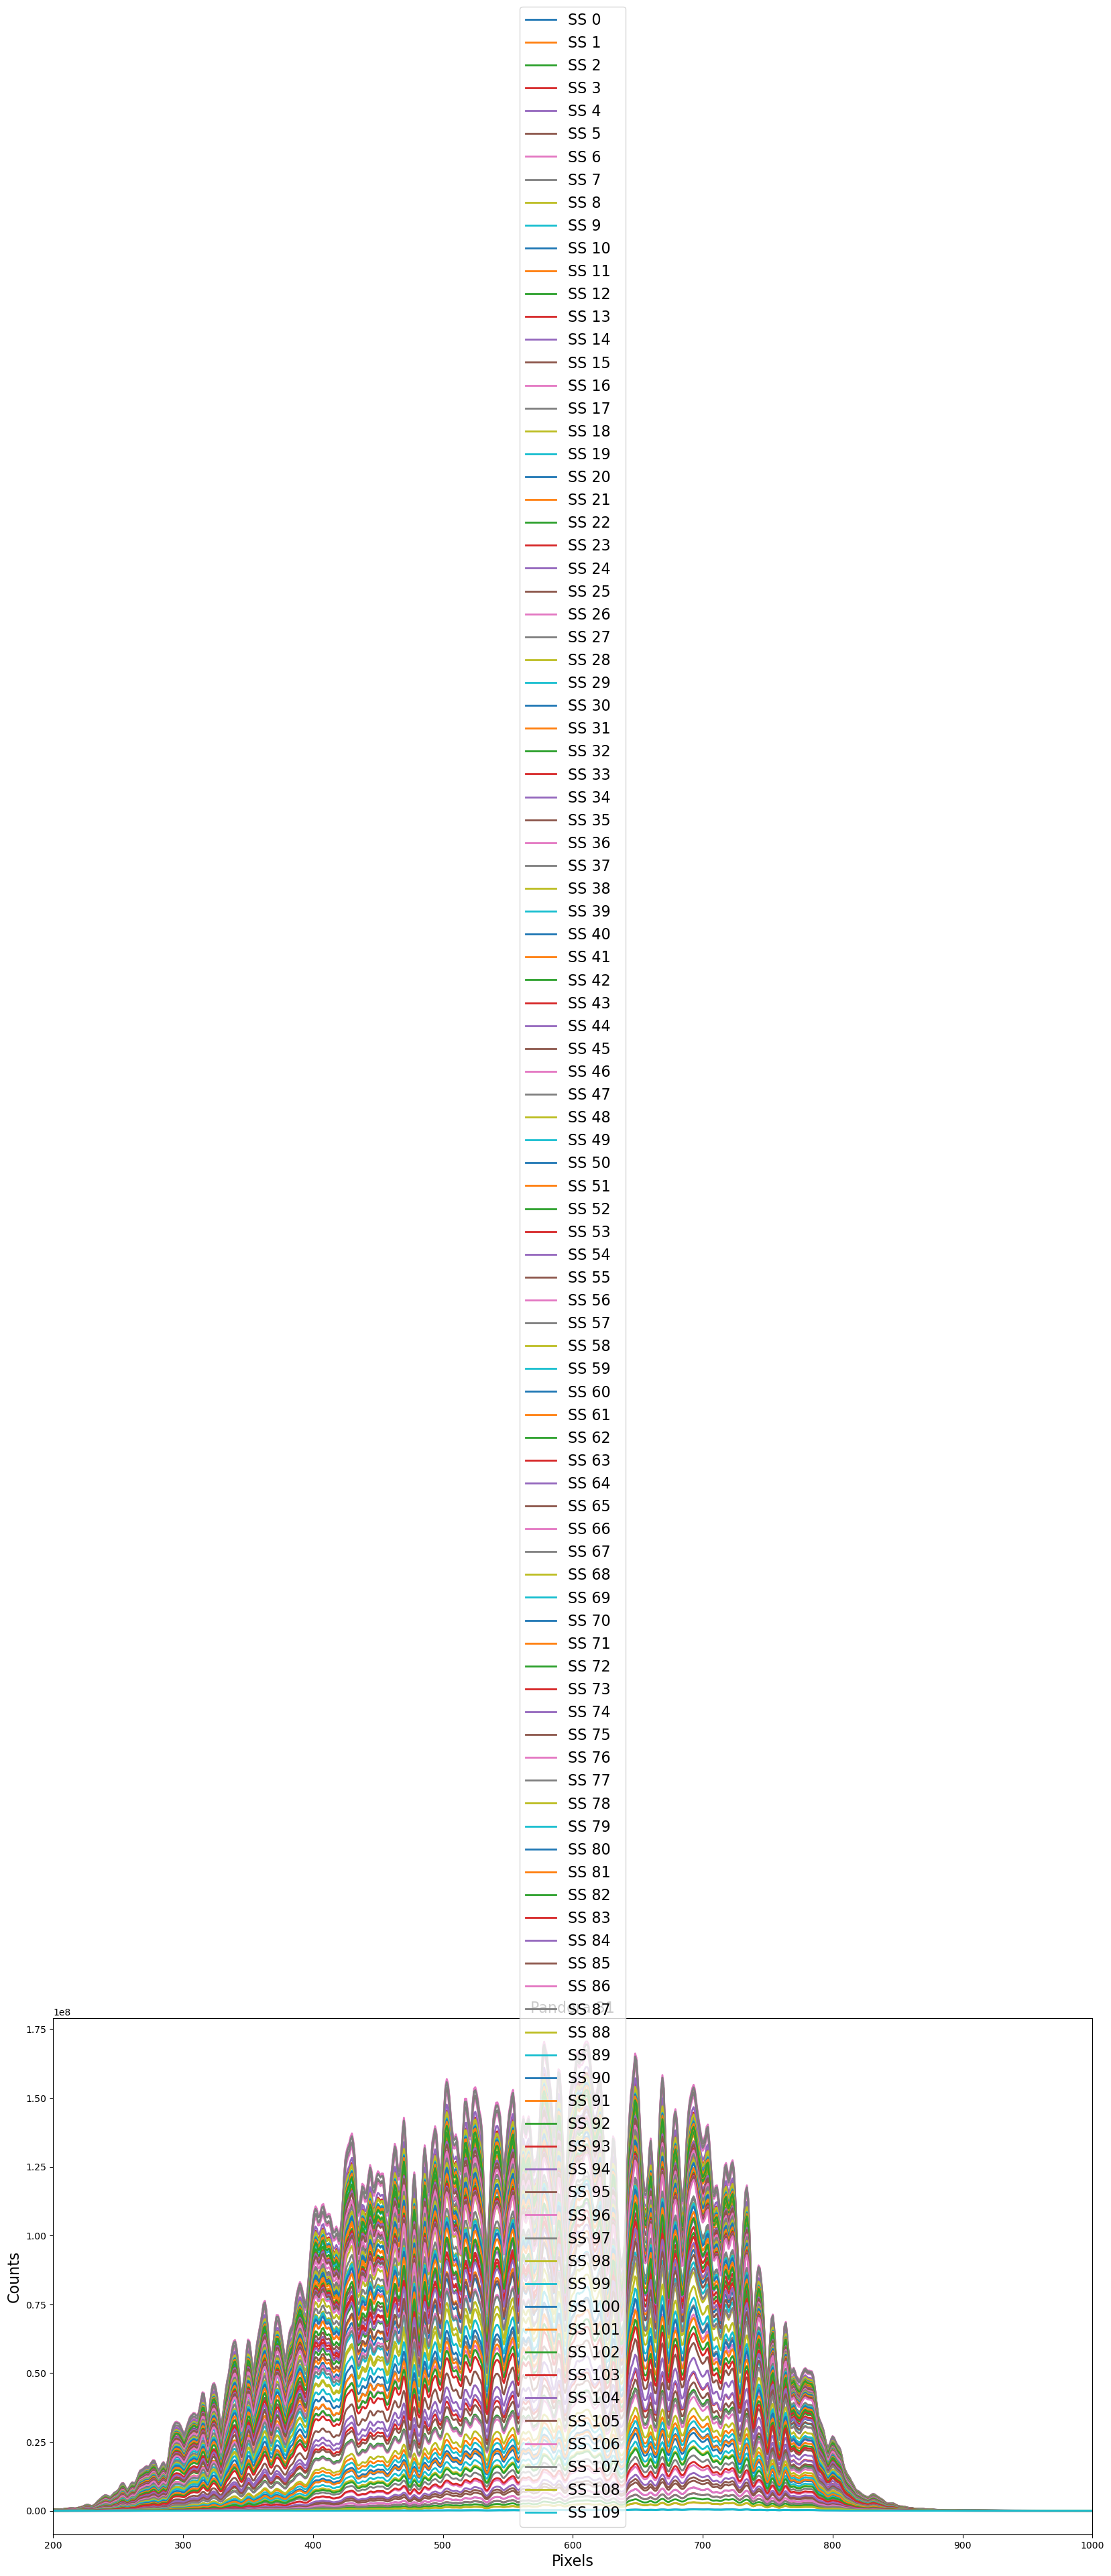

In [159]:
# Define the conditions
conditions = {
    "SS_bc": (data1[0] == "SS") & (data1[8] == 1) & (data1[9] == 5),
    "SS_dc": (data1[0] == "SS") & (data1[8] == 1) & (data1[9] == 3)
}

# Create variables for filtered data
filtered_data = {key: data1.loc[condition, 21:2071] for key, condition in conditions.items()}

# Extract the data and calculate the mean
SS_bc_l0 = filtered_data["SS_bc"].reset_index(drop=True)
SS_dc_l0 = filtered_data["SS_dc"].reset_index(drop=True)

SS_bc = SS_bc_l0.iloc[:, 3:].values
SS_dc = SS_dc_l0.iloc[:, 3:].values

ss_l0 = SS_bc - SS_dc

pixels = np.arange(0, 2048)

plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.xticks(np.arange(0, 2048, 100))
for i in range(len(ss_l0)): 
    plt.plot(pixels, ss_l0[i], label=f'SS {i}', linewidth=2)

plt.xlabel('Pixels', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Pandora 31', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(200, 1000)
#plt.ylim(50, 120)
plt.show()

# L1

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

file_path = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/Mar_26_P31/Pandora31s1_CharlesCityVA_20240825/Pandora31s1_CharlesCityVA_20240825_L1_smca1c7d20240321p1-8.txt'

base_name = os.path.basename(file_path)
csv_file_name = os.path.splitext(base_name)[0] + '.csv'

# Read the entire file
with open(file_path, 'r', encoding='latin1') as file:
    lines = file.readlines()

# Extract the line containing the nominal wavelengths
nominal_wavelengths_line = lines[22].strip()  # Line 23 in the file (index 22)

# Split the line into individual wavelengths and convert them to float
wavelength = [float(value) for value in nominal_wavelengths_line.split(': ')[1].split()]

# Skip the initial 89 rows
data_lines = lines[89:]

# Process each line to split into rows and columns
data_list = []
for line in data_lines:
    # Strip the newline character and split by tabs
    rows = line.strip().split('\t')
    for row in rows:
        # Split each row by spaces
        columns = row.split()
        data_list.append(columns)

# Convert the list of lists into a DataFrame
data2 = pd.DataFrame(data_list)
# Convert the necessary columns to numeric before saving
data2.iloc[:, 2:6205] = data2.iloc[:, 2:6205].apply(pd.to_numeric, errors='coerce')

In [23]:
# Define the conditions
conditions = {
    "SS_0d_1_5": (
        (data2['routine'] == "SS") &
        (data2['filterwheel 1'] == 1) &
        (data2['filterwheel 2'] == 5)
    )
}

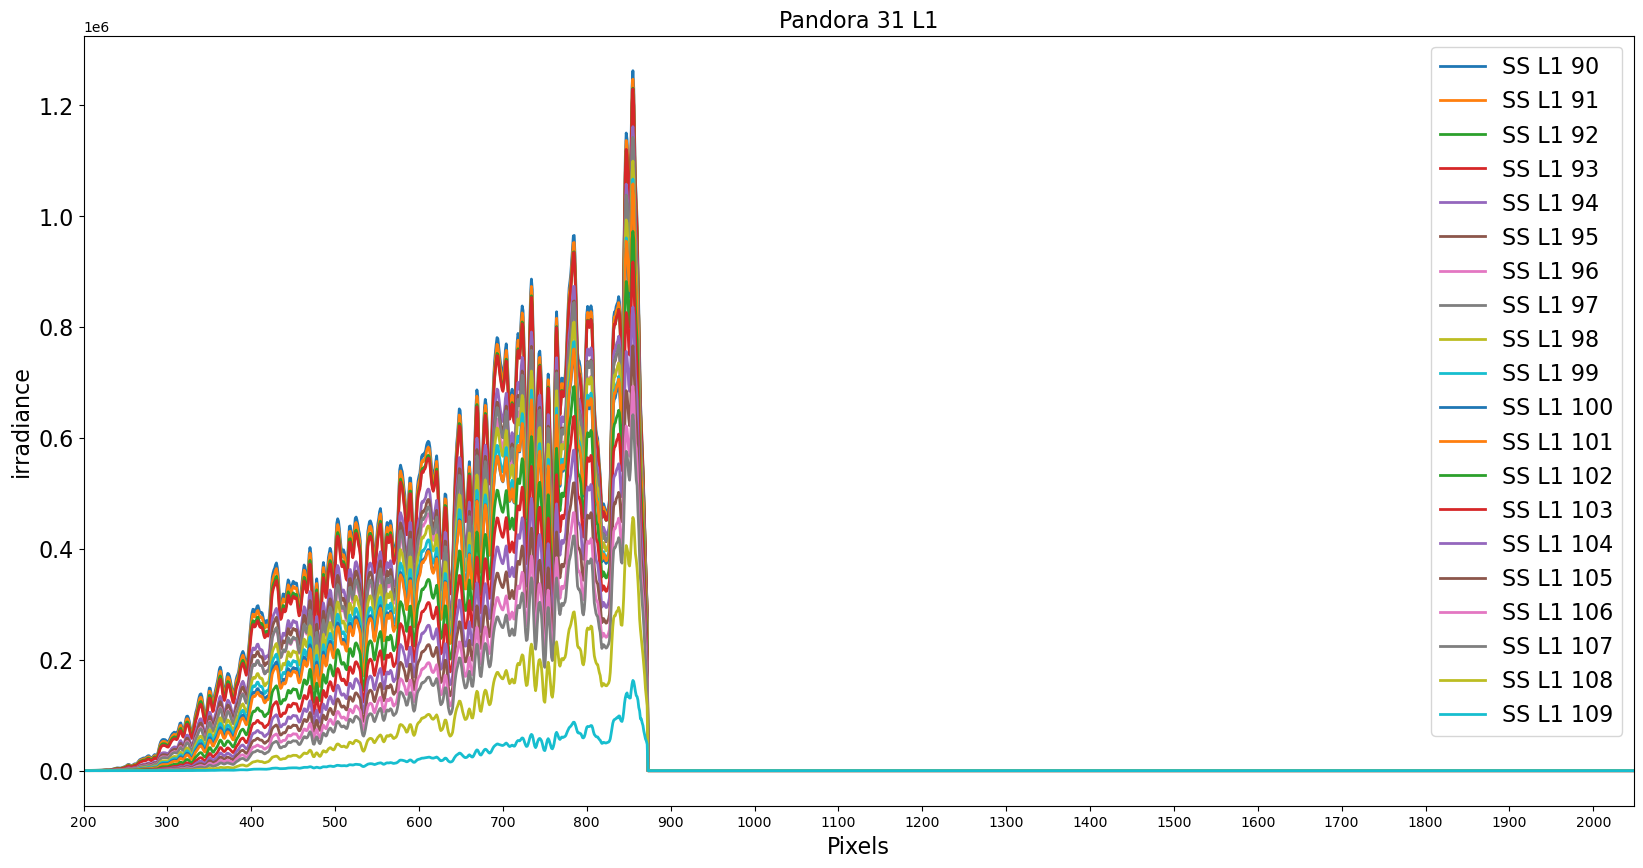

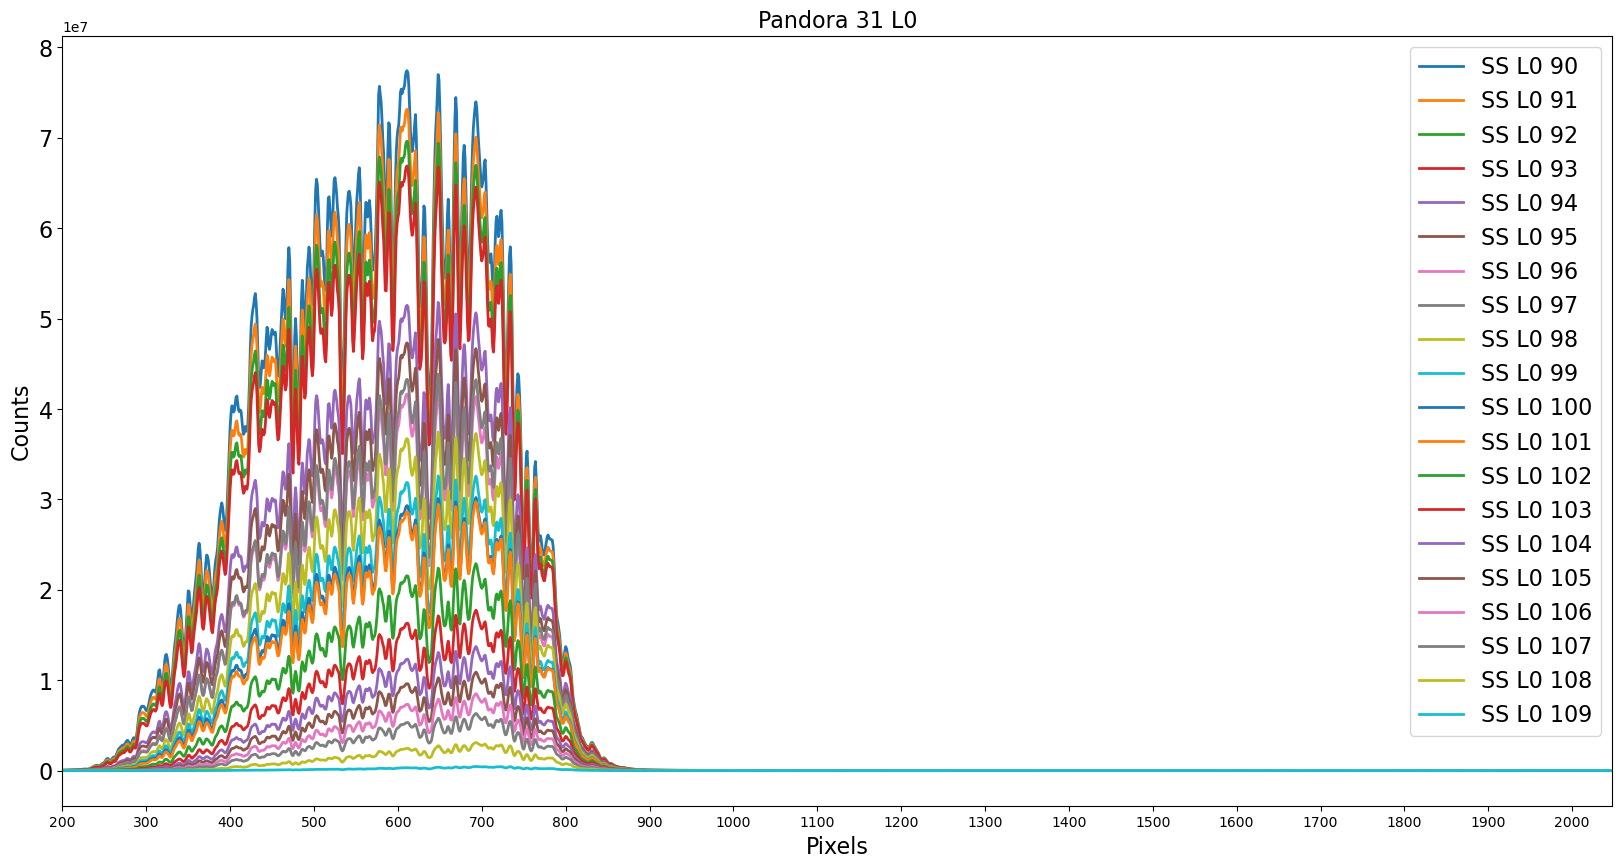

In [113]:
# Define the conditions
conditions = {
    "SS_0d_1_5": (data2[0] == "SS") & (data2[11] == 1) & (data2[12] == 5)
}

# Create variables for filtered data
filtered_data = {key: data2.loc[condition, 66:2116] for key, condition in conditions.items()}

# Extract the data and calculate the mean
SS_0d_1_5 = filtered_data["SS_0d_1_5"].reset_index(drop=True)

SS_1_5 = SS_0d_1_5.iloc[:, 3:].values


plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.xticks(np.arange(0, 2048, 100))
plt.yticks(fontsize=16)

for i in range(90,110): 
    plt.plot(SS_1_5[i], label=f'SS L1 {i}', linewidth=2)

# Set plot labels and title
plt.xlabel('Pixels', fontsize=16)
plt.ylabel('irradiance', fontsize=16)
plt.title('Pandora 31 L1', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(200, 2048)
#plt.ylim(50, 120)
plt.show()

plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.xticks(np.arange(0, 2048, 100))
plt.yticks(fontsize=16)

for i in range(90,110): 
    plt.plot(ss_l0[i], label=f'SS L0 {i}', linewidth=2)

# Set plot labels and title
plt.xlabel('Pixels', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Pandora 31 L0', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(200, 2048)
#plt.ylim(50, 120)
plt.show()

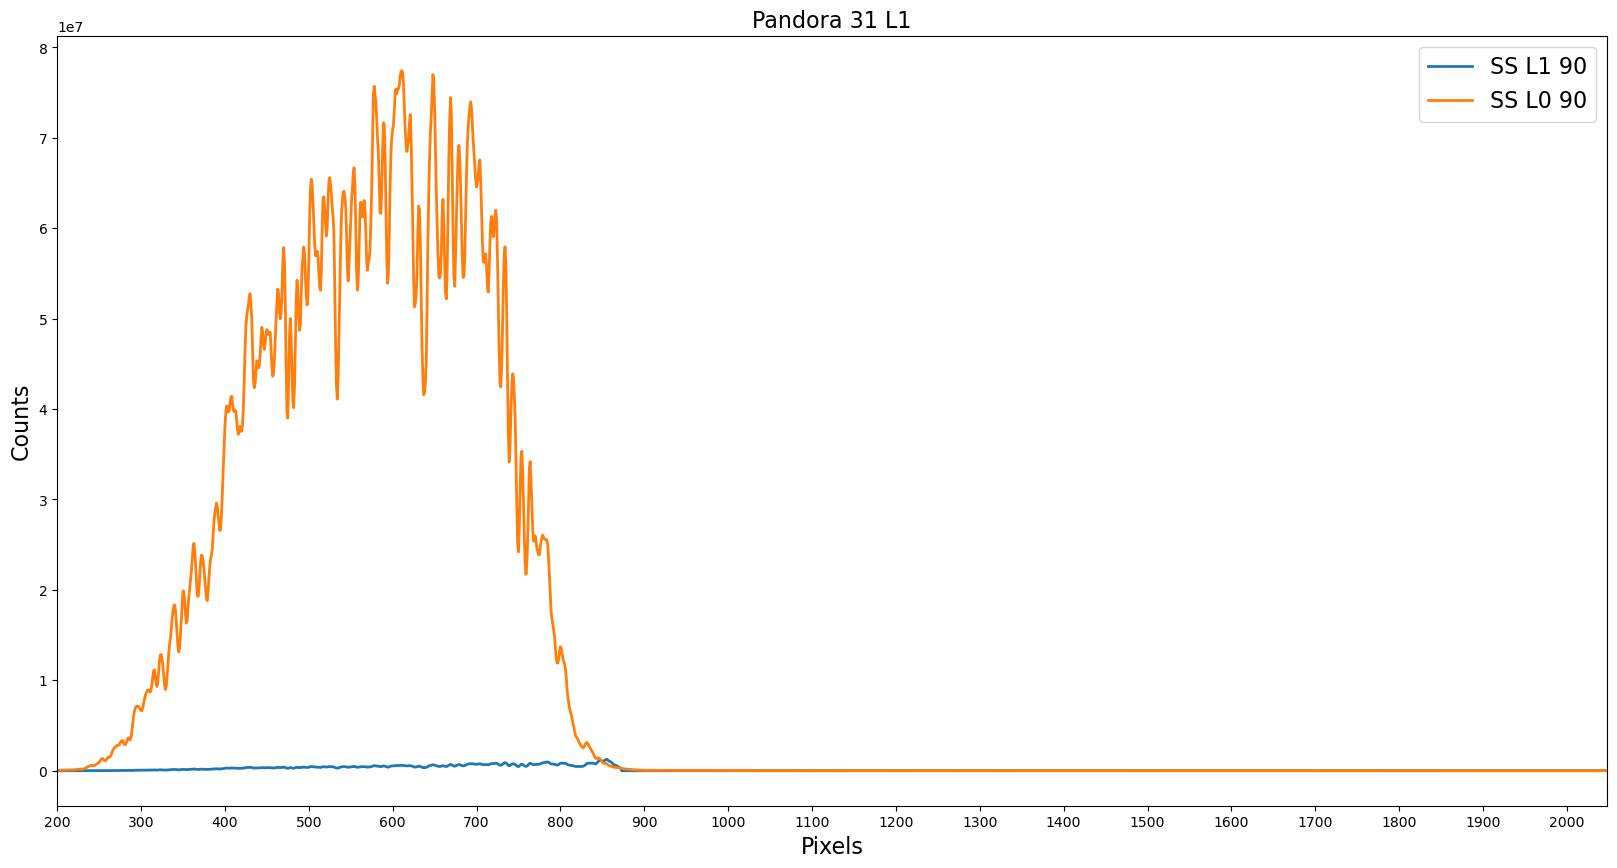

In [119]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# plt.yscale('log')
plt.xticks(np.arange(0, 2048, 100))

for i in range(90,91): 
    plt.plot(SS_1_5[i], label=f'SS L1 {i}', linewidth=2)
    plt.plot(ss_l0[i], label=f'SS L0 {i}', linewidth=2)

# Set plot labels and title
plt.xlabel('Pixels', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Pandora 31 L1', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(200, 2048)
plt.show()